In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [9]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [10]:
aloes_left = cv2.imread('data/aloes/aloeL.jpg', cv2.IMREAD_GRAYSCALE)
aloes_right = cv2.imread('data/aloes/aloeR.jpg', cv2.IMREAD_GRAYSCALE)

disparity_left = cv2.imread('data/aloes/dispL.png', cv2.IMREAD_GRAYSCALE)
disparity_right = cv2.imread('data/aloes/dispR.png', cv2.IMREAD_GRAYSCALE)

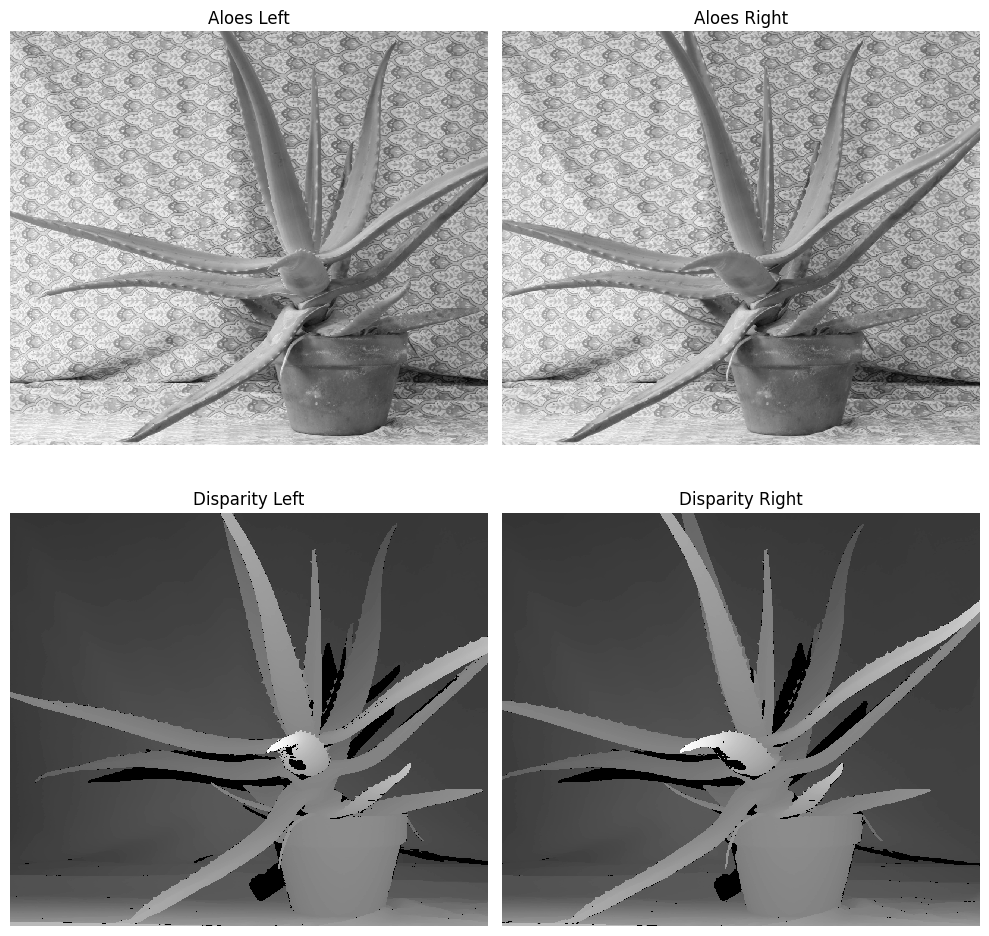

In [11]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.imshow(aloes_left)
plt.title('Aloes Left')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(aloes_right)
plt.title('Aloes Right')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(disparity_left)
plt.title('Disparity Left')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(disparity_right)
plt.title('Disparity Right')
plt.axis('off')

plt.tight_layout()
plt.show()

In [156]:
def census_transform(image: np.ndarray, *, block_size: int) -> np.ndarray:
    rows, cols = image.shape
    transformed = np.zeros((rows, cols), dtype=np.uint8)
    half_block = block_size // 2

    for r in range(half_block, rows - half_block):
        for c in range(half_block, cols - half_block):
            block = image[r - half_block: r + half_block + 1,
                          c - half_block: c + half_block + 1]
            median = np.median(block)
            
            binary_string = (block >= median).astype(np.uint8).flatten()
            binary_string = np.delete(binary_string, len(binary_string) // 2)
            
            transformed[r, c] = np.packbits(binary_string)[0]

    return transformed

In [157]:
census_left = census_transform(aloes_left, block_size=23)
census_right = census_transform(aloes_right, block_size=23)

In [166]:
def stereo_matching_census(left_image: np.ndarray, right_image: np.ndarray, *, max_disparity: int = 128, block_size: int = 23) -> np.ndarray:
    rows, cols = left_image.shape
    disparity_map = np.zeros((rows, cols), dtype=np.uint8)

    half_block = block_size // 2

    for r in range(half_block, rows - half_block):
        for c in range(half_block, cols - half_block):
            min_distance = np.inf
            best_disparity = 0

            for d in range(max_disparity):
                if c - d < 0 and r - d < 0:
                    break

                distance = bin(left_image[r, c] ^ right_image[r - d, c - d]).count('1')
                if distance < min_distance:
                    min_distance = distance
                    best_disparity = d

            disparity_map[r, c] = best_disparity

    return disparity_map

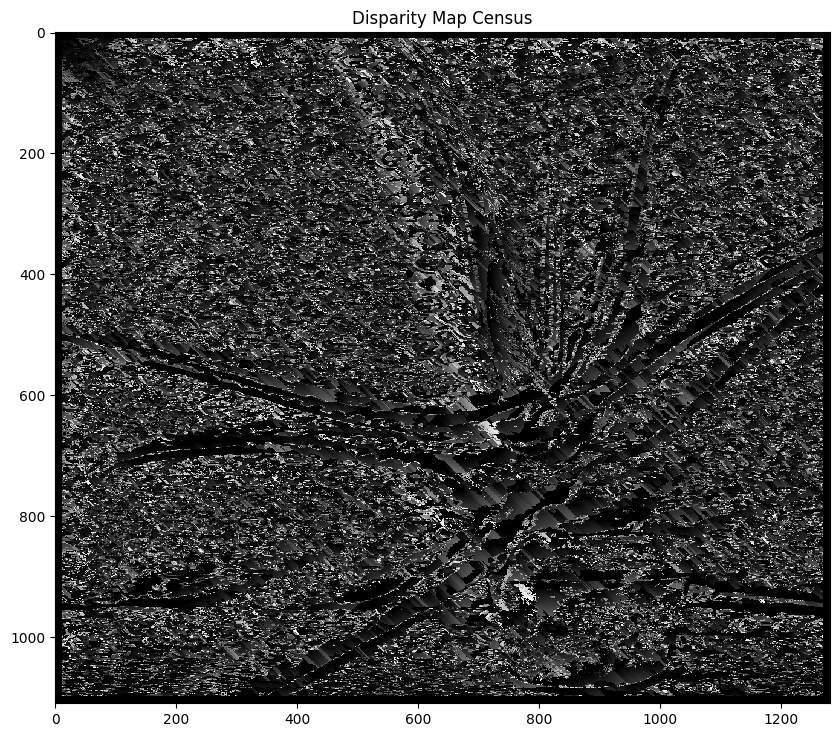

In [167]:
plt.imshow(stereo_matching_census(census_left, census_right), cmap='gray')
plt.title('Disparity Map Census')
plt.show()

In [160]:
stereo_bm = cv2.StereoBM.create(numDisparities=80, blockSize=23)

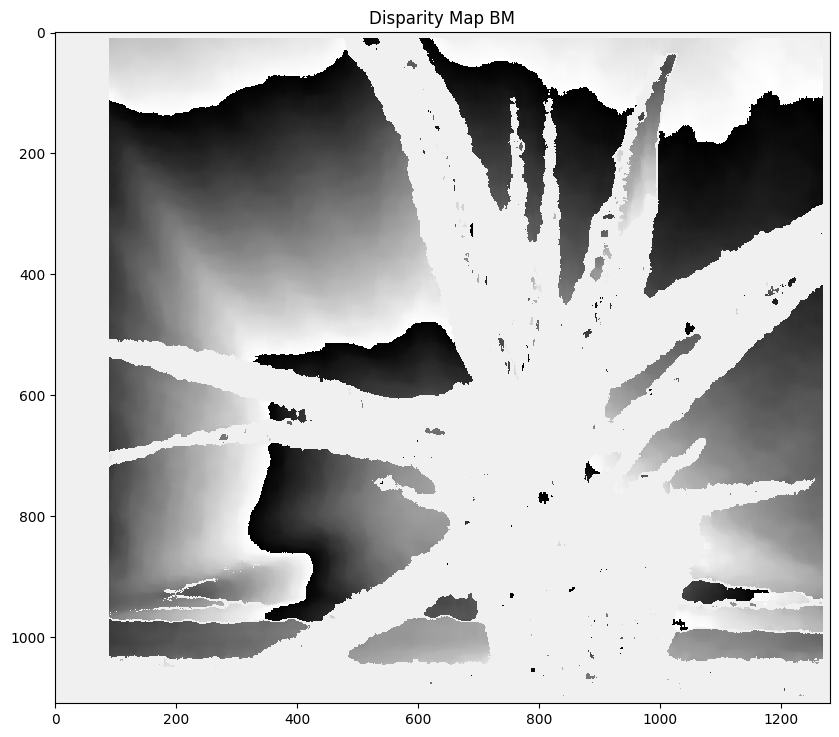

In [161]:
plt.imshow(stereo_bm.compute(aloes_left, aloes_right).astype(np.uint8), cmap='gray')
plt.title('Disparity Map BM')
plt.show()

In [154]:
stereo_sgbm = cv2.StereoSGBM.create(
    minDisparity=16,
    numDisparities=80,
    blockSize=2,
    P1=8 * 3 * 7 ** 2,
    P2=16 * 3 * 7 ** 2,
    uniquenessRatio=10,
    speckleRange=32
)

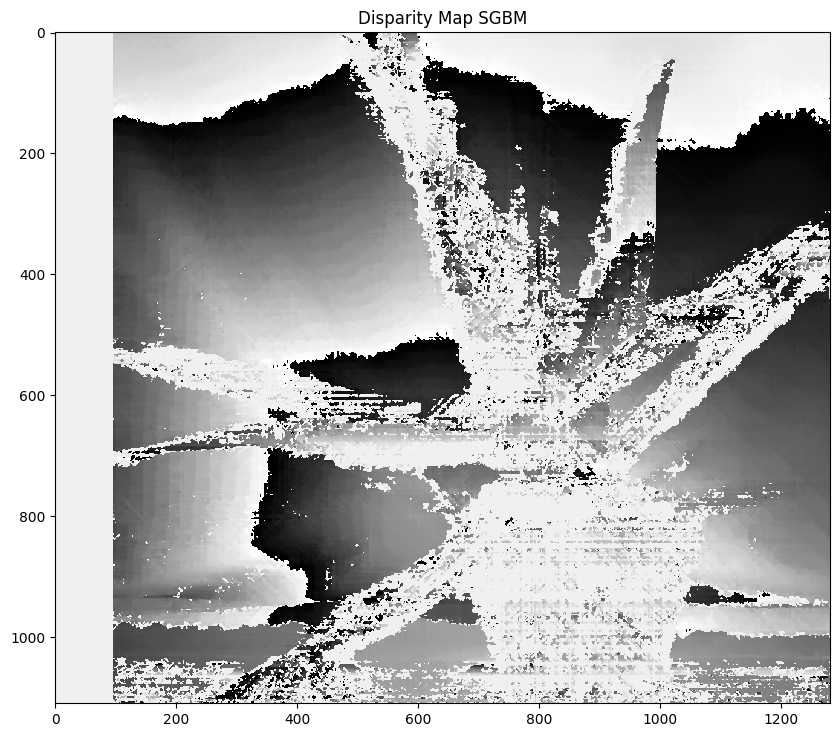

In [155]:
plt.imshow(stereo_sgbm.compute(aloes_left, aloes_right).astype(np.uint8), cmap='gray')
plt.title('Disparity Map SGBM')
plt.show()

In [35]:
import torch
from models import PSMNet

# Przetwarzanie obrazów (normalizacja, zmiana rozmiaru, itp.)
left_image_tensor = preprocess_image(left_image)
right_image_tensor = preprocess_image(right_image)

# Wczytanie modelu
model = PSMNet()
model.load_state_dict(torch.load('psmnet_pretrained.pth'))
model.eval()

# Obliczenie mapy dysparytetów
with torch.no_grad():
    disparity_map_dcnn = model(left_image_tensor, right_image_tensor)

# Wyświetlenie wyniku
plt.imshow(disparity_map_dcnn.squeeze().cpu().numpy(), cmap='gray')
plt.title('DCNN Disparity Map')
plt.show()